# Event Flagging

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

In [3]:
import sys  
sys.path.insert(0, '/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data')

In [4]:
import Metrica_IO_CF as mio
import Metrica_Viz_CF as mviz
import Metrica_Velocities_CF as mvel
import matplotlib.animation as manimation
import Metrica_PitchControl_CF as mpc

In [5]:
DATADIR = "/Volumes/Transcend/DataScience/data_bootcamp/data/cap_data"

In [6]:
game_id='/game_1'

In [7]:
events=pd.read_csv(DATADIR+game_id+'/events_cleaned.csv')

In [8]:
events=events.set_index('index')

In [9]:
tracking_home=pd.read_csv(DATADIR+game_id+'/tracking_home.csv')
tracking_away=pd.read_csv(DATADIR+game_id+'/tracking_away.csv')

In [10]:
tracking_home=tracking_home.set_index('frameIdx')
tracking_away=tracking_away.set_index('frameIdx')

In [11]:
events.columns

Index(['Team', 'Type', 'From', 'To', 'Start X', 'Start Y', 'End X', 'End Y',
       'Start Frame', 'Start Time [s]', 'Period', 'PASS_DIFFICULTY',
       'CROSSES_UNSUCCESSFUL', 'FOULS_WON', 'FOULS_CONCEDED', 'IN_BOX',
       'TACKLES_WON', 'TACKLES_LOST', 'CLEARANCE_TOTAL',
       'CLEARANCE_HEADED_WON', 'SHOTS_ON_TARGET', 'SHOTS_OFF_TARGET',
       'TAKE_ON_SUCCESSFUL', 'TAKE_ON_UNSUCCESSFUL', 'DISPOSSESSED',
       'POSSESSION_LOST', 'SHOT_QUALITY', 'SEQUENCEIDX', 'POSSESSION_EVENTS',
       'POSSESSION_START_CLOCK', 'POSSESSION_END_CLOCK',
       'POSSESSION_START_FRAMEIDX', 'POSSESSION_END_FRAMEIDX', 'FIELD_LENGTH',
       'FIELD_WIDTH', 'Event_Number', 'X_ADJ', 'Y_ADJ', 'GOAL_Y_COORDINATE',
       'GOAL_Z_COORDINATE', 'ZONE_INDEX', 'END_ZONE_INDEX', 'X_ZONE',
       'XEND_ZONE', 'Y_ZONE', 'YEND_ZONE', 'Subtype', 'frameIdx', 'ball_x',
       'ball_y', 'ball_z'],
      dtype='object')

In [12]:
#Add ball_speed to events if it is not already there
if 'ball_speed' not in events.columns:
    events=events.merge(tracking_home.reset_index()[['frameIdx','ball_speed']],how='left', on='frameIdx')


# Ball position from tracking minus ball position from events

In [13]:
events.columns

Index(['Team', 'Type', 'From', 'To', 'Start X', 'Start Y', 'End X', 'End Y',
       'Start Frame', 'Start Time [s]', 'Period', 'PASS_DIFFICULTY',
       'CROSSES_UNSUCCESSFUL', 'FOULS_WON', 'FOULS_CONCEDED', 'IN_BOX',
       'TACKLES_WON', 'TACKLES_LOST', 'CLEARANCE_TOTAL',
       'CLEARANCE_HEADED_WON', 'SHOTS_ON_TARGET', 'SHOTS_OFF_TARGET',
       'TAKE_ON_SUCCESSFUL', 'TAKE_ON_UNSUCCESSFUL', 'DISPOSSESSED',
       'POSSESSION_LOST', 'SHOT_QUALITY', 'SEQUENCEIDX', 'POSSESSION_EVENTS',
       'POSSESSION_START_CLOCK', 'POSSESSION_END_CLOCK',
       'POSSESSION_START_FRAMEIDX', 'POSSESSION_END_FRAMEIDX', 'FIELD_LENGTH',
       'FIELD_WIDTH', 'Event_Number', 'X_ADJ', 'Y_ADJ', 'GOAL_Y_COORDINATE',
       'GOAL_Z_COORDINATE', 'ZONE_INDEX', 'END_ZONE_INDEX', 'X_ZONE',
       'XEND_ZONE', 'Y_ZONE', 'YEND_ZONE', 'Subtype', 'frameIdx', 'ball_x',
       'ball_y', 'ball_z', 'ball_speed'],
      dtype='object')

## Calculate the distance between the event start coordinates and the ball position coordinates

This provides an idea on how well the events are labelled

In [14]:
dist=np.sqrt((events['Start X']-events['ball_x'])**2 +(events['Start Y']-events['ball_y'])**2)

In [15]:
events['dist']=dist

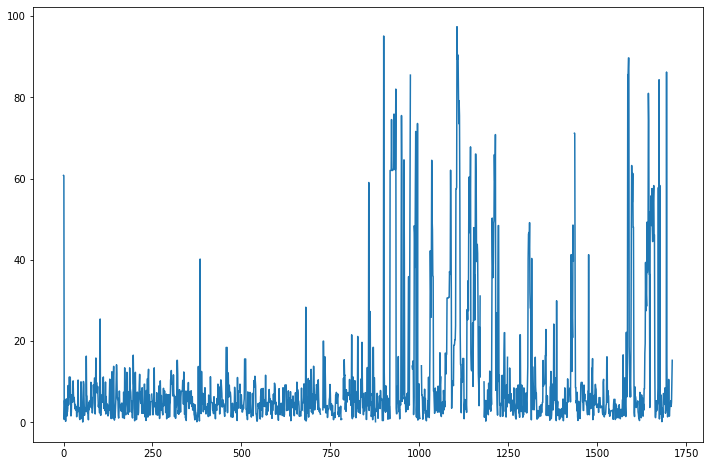

In [16]:
plt.figure(figsize=(12,8))
plt.plot(events['dist'])

In [17]:
len(events[events['dist']>20])

195

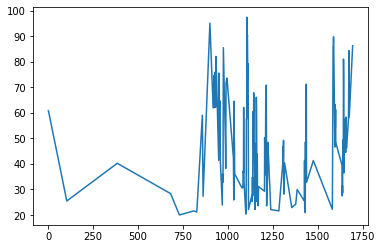

In [18]:
plt.plot(events['dist'][events['dist']>20])

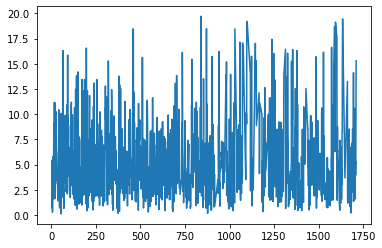

In [19]:
plt.plot(events['dist'][events['dist']<20])

## Shouldn't it be close to 0??

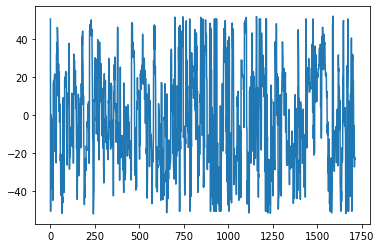

In [20]:
plt.plot(events['Start X'])

In [21]:
bad_events=events[events['dist']>20]

## plotting "bad" events

<AxesSubplot:xlabel='dist', ylabel='Count'>

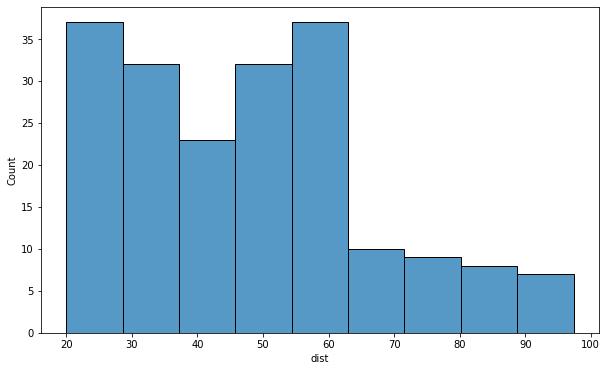

In [22]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(x='dist',data=bad_events)

## Build out dictionary with player id and jersey number

In [23]:
player_id_num=pd.read_csv(DATADIR+game_id+'/player_id_num.csv')

In [24]:
# initializing lists 
test_keys = list(player_id_num['playerId'])
test_values = list(player_id_num['jersey_num'])
# using zip() 
# to convert lists to dictionary 
player_dict = dict(zip(test_keys, test_values)) 

## Change events "From" from player ID to jersey number so it matches tracking data


In [25]:
def isNaN(num):
    '''cute lil guy that determines if an element is nan or not'''
    return num != num

In [26]:
#Creating Sybtype column

jersey_num=[]
for i in range(len( events)):
    if isNaN(events['From'].iloc[i]):
        jersey_num.append(np.nan)
    else:
        jersey_num.append(player_dict[events['From'].iloc[i]])

    

In [27]:
if len(jersey_num) == events.shape[0]:
    events['From']=jersey_num
else:
    'uh oh, you\'ve got a length mismatch between your list and the events dataframe'

In [28]:
jersey_num=[]
for i in range(len( events)):
    if isNaN(events['To'].iloc[i]):
        jersey_num.append(np.nan)
    else:
        jersey_num.append(player_dict[events['To'].iloc[i]])

    

In [29]:
if len(jersey_num) == events.shape[0]:
    events['To']=jersey_num
else:
    'uh oh, you\'ve got a length mismatch between your list and the events dataframe'

In [30]:
len(jersey_num)

1712

# Quantifying Pass probability

## Defining Home/Away Passes for analysis

In [31]:
# away passes
away_passes=events[(events['Subtype']=='Pass') & (events['Team']=="Away")]

In [32]:
away_passes.shape

(642, 53)

In [33]:
# home passes
home_passes=events[(events['Subtype']=='Pass') & (events['Team']=="Home")]

In [34]:
home_passes.shape

(416, 53)

# AWAY TEAM ASSESSMENT

In [35]:
# first get pitch control model parameters
params = mpc.default_model_params()

In [37]:
params['average_ball_speed']

15.0

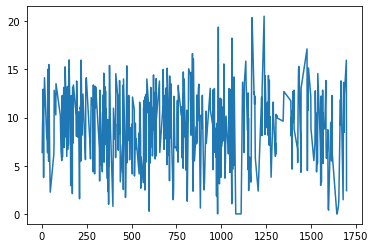

In [38]:
plt.plot(away_passes['ball_speed'])

#### Ball speed seems to be dramatically overestimated in the original model. 

Added ball speed as an input to pitch control calculation so it correctly takes in ball speed as a parameter instead of assuming 15 m/s.

There was an issue with using ball speed as input when it was 0, therefore changed the code so if it is set as 0, assume median ball speed (calculated, not the 15 m/s)

In [45]:
away_passes['ball_speed'].median()

9.325

## Original calculation of pass success probability without adjusting for bad events

In [41]:
away_pass_success_probability=[]

In [42]:
for i,row in away_passes.iterrows():
    ### This if statement checks if more than 90/107 rows are nan, if so, it skips
    if list(tracking_home[tracking_home.index==row['Start Frame']].isnull().sum(axis=1))[0]>90:
        away_pass_success_probability.append( (i,np.nan) )
    else:
        pass_start_pos = np.array([row['ball_x'],row['ball_y']])
        pass_target_pos = np.array([row['End X'],row['End Y']])
        pass_frame = row['Start Frame']
        # find goalkeepers for offside calculation and so player initialization works properly 
        #      - calculating them for each frame in case of substitutions
        GK_numbers = [mio.find_goalkeeper(tracking_home,int(row['Start Frame'])),
                      mio.find_goalkeeper(tracking_away,int(row['Start Frame']))]
        attacking_players = mpc.initialise_players(tracking_away.loc[pass_frame],'away',params, GK_numbers[1])
        defending_players = mpc.initialise_players(tracking_home.loc[pass_frame],'home',params, GK_numbers[0])
        if row['ball_speed']==0:
            ballspeed=away_passes['ball_speed'].median()
        else:    
            ballspeed=row['ball_speed']
            
        Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params,ball_speed=ballspeed)

        away_pass_success_probability.append( (i,Patt) )

In [43]:
len(away_pass_success_probability)

642

Text(0, 0.5, 'Frequency')

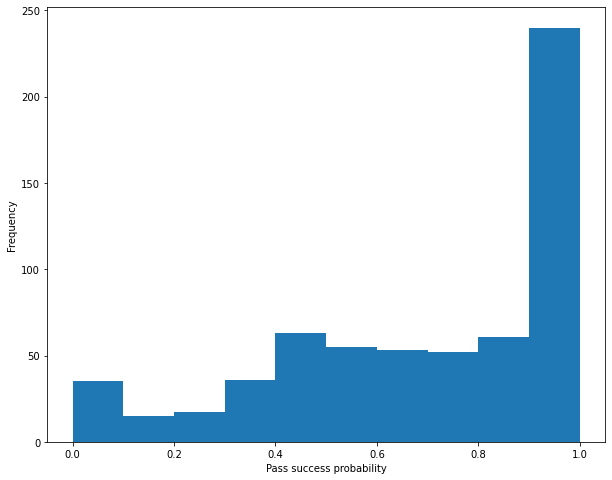

In [44]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist( [p[1] for p in away_pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  


## New Pass Success Probability calculation with the badly labelled events removed

In [47]:
away_pass_success_probability=[]

In [48]:
for i,row in away_passes[away_passes['dist']<20].iterrows():
    ### This if statement checks if more than 90/107 rows are nan, if so, it skips
    if list(tracking_home[tracking_home.index==row['Start Frame']].isnull().sum(axis=1))[0]>90:
        away_pass_success_probability.append( (i,np.nan) )
    else:
        pass_start_pos = np.array([row['Start X'],row['Start Y']])
        pass_target_pos = np.array([row['End X'],row['End Y']])
        pass_frame = row['Start Frame']
        # find goalkeepers for offside calculation and so player initialization works properly 
        #      - calculating them for each frame in case of substitutions
        GK_numbers = [mio.find_goalkeeper(tracking_home,int(row['Start Frame'])),
                      mio.find_goalkeeper(tracking_away,int(row['Start Frame']))]
        attacking_players = mpc.initialise_players(tracking_away.loc[pass_frame],'away',params, GK_numbers[1])
        defending_players = mpc.initialise_players(tracking_home.loc[pass_frame],'home',params, GK_numbers[0])
        
        if row['ball_speed']==0:
            ballspeed=away_passes['ball_speed'].median()
        else:    
            ballspeed=row['ball_speed']
        Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params,ball_speed=ballspeed)

        away_pass_success_probability.append( (i,Patt) )

In [49]:
len(away_pass_success_probability)

586

(642-586) **56 passes were excluded**

Text(0.5, 1.0, 'Pass Success Probability Histogram')

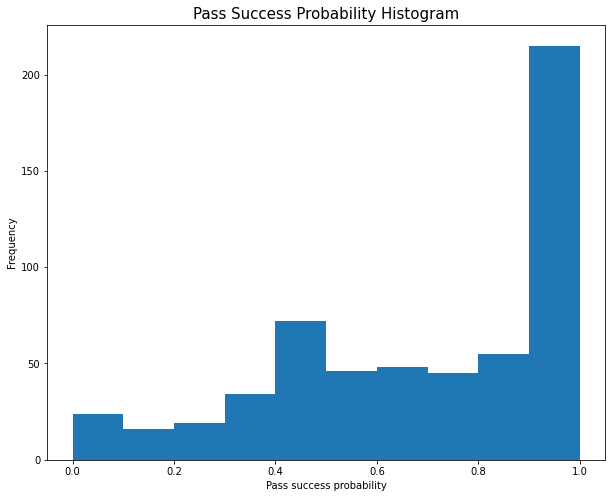

In [50]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist( [p[1] for p in away_pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  
ax.set_title('Pass Success Probability Histogram',fontsize=15)


# HOME TEAM ASSESSMENT

## New Pass Success Probability calculation with the badly labelled events removed

In [51]:
home_pass_success_probability=[]

In [52]:
for i,row in home_passes[home_passes['dist']<20].iterrows():
    ### This if statement checks if more than 90/107 rows are nan, if so, it skips
    if list(tracking_home[tracking_home.index==row['Start Frame']].isnull().sum(axis=1))[0]>90:
        home_pass_success_probability.append( (i,np.nan) )
    else:
        pass_start_pos = np.array([row['Start X'],row['Start Y']])
        pass_target_pos = np.array([row['End X'],row['End Y']])
        pass_frame = row['Start Frame']
        # find goalkeepers for offside calculation and so player initialization works properly 
        #      - calculating them for each frame in case of substitutions
        GK_numbers = [mio.find_goalkeeper(tracking_home,int(row['Start Frame'])),
                      mio.find_goalkeeper(tracking_away,int(row['Start Frame']))]
        attacking_players = mpc.initialise_players(tracking_away.loc[pass_frame],'away',params, GK_numbers[1])
        defending_players = mpc.initialise_players(tracking_home.loc[pass_frame],'home',params, GK_numbers[0])
        if row['ball_speed']==0:
            ballspeed=home_passes['ball_speed'].median()
        else:    
            ballspeed=row['ball_speed']
        Patt,Pdef = mpc.calculate_pitch_control_at_target(pass_target_pos, attacking_players, defending_players, pass_start_pos, params, ball_speed=ballspeed)

        home_pass_success_probability.append( (i,Patt) )

In [53]:
len(home_pass_success_probability)

381

Text(0, 0.5, 'Frequency')

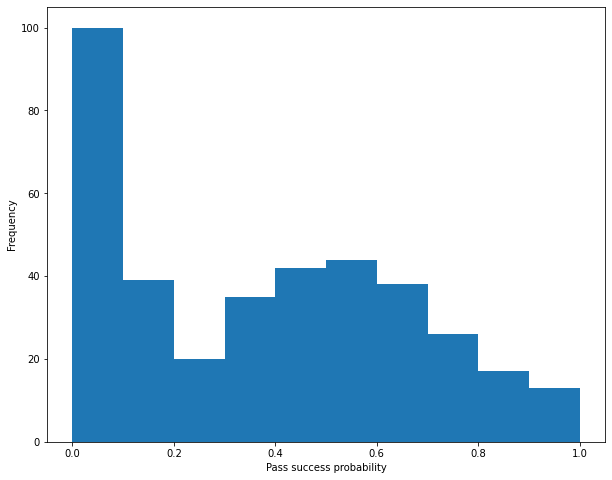

In [54]:
fig,ax = plt.subplots(figsize=(10,8))
ax.hist( [p[1] for p in home_pass_success_probability], np.arange(0,1.1,0.1))    
ax.set_xlabel('Pass success probability')
ax.set_ylabel('Frequency')  


## Could try another tactic by measuring distance between "From" player to ball
Tried this, but it only helps with identifying mislabelled events, not with the accuracy - ball position is used for that

## I'll have to merge events and tracking together to get this info

In [55]:
tracking_all=tracking_home.reset_index().merge(tracking_away.reset_index().drop(['Time [s]','Period','ball_x',
                                                                                 'ball_y','ball_z','ball_speed'],axis=1),how='left',on='frameIdx')

In [56]:
columns_home_velocity=[c for c in tracking_home.keys() if ((c[-3:]=='_vx') or (c[-6:]=='_speed') ) and ((c[0:4]=="home") and ((c[0:4]!="ball")))]

In [57]:
columns_away_velocity=[c for c in tracking_away.keys() if ((c[-3:]=='_vx' ) or (c[-6:]=='_speed')) and ((c[0:4]!="home") and (c[0:4]!="ball"))]

In [58]:
columns_all=columns_home_velocity+columns_away_velocity

In [59]:
tracking_all.drop(columns_all,axis=1)

,frameIdx,home_2_x,home_2_y,home_2_z,home_4_x,home_4_y,home_4_z,home_5_x,home_5_y,home_5_z,...,away_3_vy,away_31_vy,away_32_vy,away_35_vy,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy
0,0,NaN,NaN,NaN,18.47,-2.79,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,18.47,-2.80,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,18.47,-2.82,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,18.45,-2.84,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,NaN,NaN,NaN,18.43,-2.87,0.0,NaN,NaN,NaN,...,0.285714,NaN,0.0,NaN,NaN,NaN,-0.357143,NaN,0.142857,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139057,139057,-11.08,5.93,0.0,NaN,NaN,NaN,-20.76,5.18,0.0,...,NaN,0.0,NaN,0.250000,0.571429,0.964286,NaN,0.500000,NaN,0.0
139058,139058,-11.02,5.92,0.0,NaN,NaN,NaN,-20.78,5.15,0.0,...,NaN,0.0,NaN,0.142857,0.571429,0.964286,NaN,0.464286,NaN,0.0
139059,139059,-10.98,5.92,0.0,NaN,NaN,NaN,-20.81,5.11,0.0,...,NaN,0.0,NaN,-0.008929,0.589286,0.955357,NaN,0.410714,NaN,0.0
139060,139060,-10.95,5.92,0.0,NaN,NaN,NaN,-20.84,5.07,0.0,...,NaN,0.0,NaN,-0.160714,0.607143,0.946429,NaN,0.357143,NaN,0.0


In [60]:
new_events=events.drop(['ball_x','ball_y','ball_z'],axis=1).merge(tracking_all.reset_index().drop(columns_all,axis=1),how='left',on='frameIdx')

## Measure distance between `From` and `ball`


In [61]:
## the distance to 100 m if the player name is nan, meaning they are not on the field
## The loop calculates dispance between the "from" player (or player on the ball making the event) and the ball position

dist_btw=[]
for i,row in new_events.iterrows():
    if isNaN(row['From']):
        dist_btw.append(100)
    #elif isNaN():    
    else:
        tempx=row['Team'].lower() + '_' +str(int(row['From']))+ '_x'
        tempy=row['Team'].lower() + '_' +str(int(row['From']))+ '_y'
        dist_x=(row[tempx]-row['ball_x'])**2
        dist_y=(row[tempy]-row['ball_y'])**2
        #print(np.sqrt(dist_x+dist_y))
        dist_btw.append(np.sqrt(dist_x+dist_y))

In [66]:
len(dist_btw)

1712

In [63]:
new_events['dist_btw']=dist_btw

In [64]:
len(new_events[new_events['dist_btw']>40])

138

In [67]:
new_events[new_events['dist_btw']>40].sort_values(by='dist_btw')

,Team,Type,From,To,Start X,Start Y,End X,End Y,Start Frame,Start Time [s],...,away_31_vy,away_32_vy,away_35_vy,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy,dist_btw
549,Away,5,15.0,NaN,-0.3021,34.952,NaN,NaN,36327.0,1453.08,...,NaN,0.714286,NaN,NaN,NaN,0.285714,NaN,0.500000,NaN,40.046076
993,Away,1,9.0,15.0,-31.1163,19.584,-26.6855,31.28,74805.0,2992.20,...,5.392857,NaN,4.000000,NaN,3.178571,NaN,0.178571,NaN,1.214286,40.055851
1660,Away,5,1.0,NaN,-51.5584,25.364,NaN,NaN,133332.0,5333.28,...,0.535714,NaN,0.250000,0.035714,0.392857,NaN,-0.821429,NaN,0.928571,40.074763
380,Home,5,4.0,NaN,-25.4771,34.884,NaN,NaN,25983.0,1039.32,...,NaN,2.500000,NaN,NaN,NaN,0.035714,NaN,1.464286,NaN,40.143926
1343,Away,49,12.0,NaN,-31.2170,23.188,NaN,NaN,111165.0,4446.60,...,2.250000,NaN,1.821429,2.750000,0.750000,NaN,0.464286,NaN,1.285714,40.395902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1211,Home,40,NaN,NaN,50.3500,34.000,NaN,NaN,95116.0,3804.64,...,-0.035714,NaN,0.214286,0.000000,-0.142857,NaN,-0.535714,NaN,-0.071429,100.000000
1214,Home,68,NaN,NaN,50.3500,34.000,NaN,NaN,94919.0,3796.76,...,-0.285714,NaN,-0.714286,NaN,0.285714,NaN,-0.142857,NaN,-0.785714,100.000000
1476,Home,40,NaN,NaN,50.3500,34.000,NaN,NaN,119334.0,4773.36,...,1.714286,NaN,1.000000,0.821429,0.535714,NaN,1.000000,NaN,0.321429,100.000000
727,Away,28,NaN,NaN,-50.3500,-34.000,NaN,NaN,52512.0,2100.48,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


# Try out ways of flagging bad events

In [68]:
test_events=copy.deepcopy(new_events)

In [69]:
# putting `dist` column at the end so I can easily see it when I call the dataframe
test_events=test_events[list(new_events.drop(['dist'],axis=1).columns)+['dist']]

### First one is to filter the events when the distance between ball and start location (in event) is greater than 7 AND the distance between the ball carrier and the ball is greater than 15 m

In [70]:
test_events[(test_events['dist']>7)&(test_events['dist_btw']>15)]

,Team,Type,From,To,Start X,Start Y,End X,End Y,Start Frame,Start Time [s],...,away_32_vy,away_35_vy,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy,dist_btw,dist
0,Home,32,NaN,NaN,50.3500,34.000,NaN,NaN,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,60.782170
1,Away,32,NaN,NaN,-50.3500,-34.000,NaN,NaN,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,60.727063
16,Away,44,3.0,NaN,16.5148,-5.372,NaN,NaN,1454.0,58.16,...,-0.750000,NaN,NaN,NaN,0.750000,NaN,0.321429,NaN,25.018925,11.159377
85,Home,1,6.0,40.0,21.6505,-1.700,22.7582,7.616,5578.0,223.12,...,-3.000000,NaN,NaN,NaN,-1.928571,NaN,-2.964286,NaN,22.876210,7.280958
86,Home,1,40.0,29.0,22.7582,7.616,17.7232,11.288,5629.0,225.16,...,0.535714,NaN,NaN,NaN,0.571429,NaN,1.892857,NaN,19.920916,7.177574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1689,Home,49,27.0,NaN,10.9763,26.180,NaN,NaN,137164.0,5486.56,...,NaN,0.750000,-1.392857,2.392857,NaN,6.178571,NaN,0.000000,21.011016,7.095865
1691,Home,1,12.0,14.0,19.5358,11.084,40.3807,2.720,137263.0,5490.52,...,NaN,0.678571,-2.714286,0.607143,NaN,-5.892857,NaN,-0.107143,24.513906,8.525363
1695,Away,70,NaN,NaN,-50.3500,-34.000,NaN,NaN,137429.0,5497.16,...,NaN,1.142857,2.035714,1.000000,NaN,2.428571,NaN,0.071429,100.000000,86.221519
1701,Home,1,12.0,25.0,29.3037,29.580,15.5078,9.044,138093.0,5523.72,...,NaN,-0.785714,-0.357143,0.357143,NaN,-0.178571,NaN,-0.071429,58.826719,10.587011


### Second one is to label "Good" events where the players aren't labelled properly
filter the events when the distance between ball and start location (in event) is LESS than 7 AND the distance between the ball carrier and the ball is GREATER than 20 m

In [71]:
test_events[(test_events['dist']<7)&(test_events['dist_btw']>20)]

,Team,Type,From,To,Start X,Start Y,End X,End Y,Start Frame,Start Time [s],...,away_32_vy,away_35_vy,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy,dist_btw,dist
2,Away,1,3.0,13.0,0.2014,0.000,-15.8099,-0.272,9.0,0.36,...,-0.214286,NaN,NaN,NaN,-0.678571,NaN,0.035714,NaN,22.565888,0.735762
34,Home,8,40.0,NaN,31.4184,-32.232,NaN,NaN,2461.0,98.44,...,-1.000000,NaN,NaN,NaN,0.500000,NaN,0.714286,NaN,36.647784,3.055911
35,Home,5,40.0,NaN,32.4254,-34.816,NaN,NaN,2471.0,98.84,...,-0.107143,NaN,NaN,NaN,0.750000,NaN,0.107143,NaN,38.289612,3.916035
36,Away,5,20.0,NaN,32.4254,-34.816,NaN,NaN,2471.0,98.84,...,-0.107143,NaN,NaN,NaN,0.750000,NaN,0.107143,NaN,55.971187,3.916035
38,Away,1,20.0,28.0,28.9009,-29.648,45.9192,-30.804,2791.0,111.64,...,0.214286,NaN,NaN,NaN,-0.392857,NaN,-0.357143,NaN,32.450931,3.680772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,Home,1,25.0,16.0,15.5078,9.044,19.7372,-3.468,138184.0,5527.36,...,NaN,-2.750000,-1.642857,-1.500000,NaN,-1.250000,NaN,-0.035714,23.444225,4.501727
1703,Home,1,16.0,6.0,18.0253,-6.324,4.4308,-30.260,138264.0,5530.56,...,NaN,-4.071429,-2.464286,-3.642857,NaN,-2.000000,NaN,0.000000,22.826566,1.547168
1705,Home,1,17.0,18.0,-22.2547,-29.172,-13.4938,-20.264,138424.0,5536.96,...,NaN,-1.071429,-1.107143,1.357143,NaN,-1.285714,NaN,0.178571,36.334204,4.507094
1707,Home,1,16.0,12.0,-5.5385,-15.504,-4.5315,6.188,138522.0,5540.88,...,NaN,2.571429,1.285714,2.178571,NaN,1.321429,NaN,-0.178571,30.446156,5.350553


In [72]:
print('There are {} Events in the "Good" event, but wrongly labelled with player category'.format(len(test_events[(test_events['dist']<7)&(test_events['dist_btw']>20)])))

There are 310 Events in the "Good" event, but wrongly labelled with player category


In [73]:
print('There are {} Events in the "Bad" event category'.format(len(test_events[(test_events['dist']>7)&(test_events['dist_btw']>15)])))

There are 238 Events in the "Bad" event category


In [74]:
test_events.columns

Index(['Team', 'Type', 'From', 'To', 'Start X', 'Start Y', 'End X', 'End Y',
       'Start Frame', 'Start Time [s]',
       ...
       'away_32_vy', 'away_35_vy', 'away_53_vy', 'away_56_vy', 'away_6_vy',
       'away_7_vy', 'away_87_vy', 'away_9_vy', 'dist_btw', 'dist'],
      dtype='object', length=210)

### Build column with vector direction and magnitude from start/end in events file so I can add it to the start of ball position and shift things




In [75]:
new_vec_x=[]
new_vec_y=[]
for i in range(len(events)):
    new_vec_x.append((events['End X'].iloc[i]-events['Start X'].iloc[i]) + events['ball_x'].iloc[i])
    new_vec_y.append((events['End Y'].iloc[i]-events['Start Y'].iloc[i]) + events['ball_y'].iloc[i])
    


In [76]:
test_events['new_event_end_x']=new_vec_x
test_events['new_event_end_y']=new_vec_y

In [77]:
test_events

,Team,Type,From,To,Start X,Start Y,End X,End Y,Start Frame,Start Time [s],...,away_53_vy,away_56_vy,away_6_vy,away_7_vy,away_87_vy,away_9_vy,dist_btw,dist,new_event_end_x,new_event_end_y
0,Home,32,NaN,NaN,50.3500,34.000,NaN,NaN,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,60.782170,NaN,NaN
1,Away,32,NaN,NaN,-50.3500,-34.000,NaN,NaN,0.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,60.727063,NaN,NaN
2,Away,1,3.0,13.0,0.2014,0.000,-15.8099,-0.272,9.0,0.36,...,NaN,NaN,-0.678571,NaN,0.035714,NaN,22.565888,0.735762,-16.5413,-0.192
3,Away,1,13.0,35.0,-15.8099,-0.272,-16.4141,-9.656,57.0,2.28,...,NaN,NaN,-2.142857,NaN,-1.071429,NaN,NaN,5.416690,-11.0642,-10.504
4,Away,1,35.0,9.0,-16.4141,-9.656,-30.3107,-10.744,89.0,3.56,...,NaN,NaN,-1.178571,NaN,-2.464286,NaN,NaN,2.842995,-27.9566,-12.338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,Home,1,16.0,12.0,-5.5385,-15.504,-4.5315,6.188,138522.0,5540.88,...,1.285714,2.178571,NaN,1.321429,NaN,-0.178571,30.446156,5.350553,-3.5730,11.452
1708,Home,1,12.0,6.0,-12.7889,7.344,-28.8002,-28.968,138659.0,5546.36,...,-0.642857,0.535714,NaN,-1.357143,NaN,0.035714,25.201766,3.929808,-27.8613,-25.152
1709,Home,1,6.0,16.0,-27.1890,-27.540,-22.0533,-19.992,138770.0,5550.80,...,-2.571429,0.142857,NaN,-1.464286,NaN,0.035714,NaN,5.045452,-20.2443,-15.282
1710,Home,1,16.0,25.0,-22.0533,-19.992,-22.2547,-8.976,138826.0,5553.04,...,1.107143,2.071429,NaN,-0.035714,NaN,0.000000,12.075570,9.477996,-17.0514,-1.054


## Code below is test function to plot events using the ball position and the original vector magnitude and direction

This code was inputted into the .py files that are imported for the pitch control model

## Doesn't look like 7 is large enough to filter out bad events that were mislabeled
Looks like 20 is the number that is right filter here

(17 worked when I was also filtering for distance of ball position to player tagged)


This code will work - run it to see what I mean:

`for i,row in test_events[(test_events['dist']>17)&(test_events['dist_btw']>15)].iterrows():
    if isNaN(row['End X']):
        print('----')
    else:
        event_frame=row['Start Frame']
        fig,ax=mviz.plot_frame(tracking_home.loc[event_frame], tracking_away.loc[event_frame],include_player_velocities=True, annotate=True)# plot the 3 events leading up to the second goal
        plot_events_new(pd.DataFrame(row).T.loc[i:i], color='y', alpha=1.0,indicators = ['Marker','Arrow'], annotate=True,figax = (fig,ax))
        ## need this line for dataset with no "receiver ID/To"
        ax.set_title("Team {}, From: {} To: {} ".format(row['Team'],row['From'],row['To']))
        ##
       ax.set_xlabel("Ball loc_tracking: {},{}, Ball loc_events: {},{}".format(tracking_home['ball_x'].loc[event_frame],
                                                                                tracking_home['ball_y'].loc[event_frame],
                                                                                round(row['Start X'],2), round(row['Start Y'],2)),fontsize=12)`

`

# Sorted Events into 3 Categories:
1. **`bad_events`** - events that are just wrongly labelled
2. **`good_event_wrongly_labelled`** - events that are labelled with the players incorrectly but are correct
3. **`good_events`** - events that are labelled correctly and are accurate

In [79]:
bad_events=test_events[test_events.index.isin(list(test_events[(test_events['dist']>20)].index))]

In [80]:
bad_events.shape

(195, 212)

In [81]:
print("By Applying this filter you get rid of {}, wrongly labelled events".format(len(test_events[(test_events['dist']>20)])))

By Applying this filter you get rid of 195, wrongly labelled events


In [82]:
events=test_events[~test_events.index.isin(list(test_events[(test_events['dist']>20)].index))]

In [83]:
events.shape

(1517, 212)

In [84]:
good_events=test_events[test_events.index.isin(list(test_events[(test_events['dist']<20)&(test_events['dist_btw']<15)].index))]

In [85]:
print("The filter finds that {}, are correctly labelled and accurate".format(len(good_events)))

The filter finds that 272, are correctly labelled and accurate


In [86]:
good_event_wrongly_labelled=events[~events.index.isin(list(events[(events['dist']<20)&(events['dist_btw']<15)].index))]

In [87]:
print("The filter finds that {}, are incorrectly labelled but accurate".format(len(good_event_wrongly_labelled)))

The filter finds that 1245, are incorrectly labelled but accurate


### Export bad, good, and wrongly labelled events

In [180]:
bad_events.to_csv(DATADIR+game_id+'/bad_events.csv')

In [181]:
good_events.to_csv(DATADIR+game_id+'/good_events.csv')

In [182]:
good_event_wrongly_labelled.to_csv(DATADIR+game_id+'/good_events_wrong_label.csv')